# Belen Experiments Various

In [64]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary, random_clifford
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import random_unitary, Operator
from qiskit.providers.fake_provider import FakeManilaV2

from qiskit import Aer

#qk.IBMQ.save_account("aaff224a30e77d3ea3af33e2e3fb1cebfbff4e33b04ef75fdbbb9e9055426f547739b68d5b93dac4d47e7828d840a212436b1c36a358f9185574ce60af9a9f53", overwrite=True) 
provider = qk.IBMQ.load_account()
provider = qk.IBMQ.get_provider(hub='ibm-q', group='open', project='main')

ibmqfactory.load_account:WARNING:2023-07-28 15:53:21,286: Credentials are already in use. The existing account in the session will be replaced.


In [65]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

def circuit_to_concat_map(circuit, p = 0.01, delta = 0.01):
    n = circuit.num_qubits
    d = 2 ** n
    channel_list = []

    

    qasm = circuit.qasm()
    prelude = []
    for line in qasm.splitlines():
        H = random_hamiltonian(d)
        U_noise = tf.linalg.expm(-1j*H*delta)
        U_noise_channel = ChoiMapStatic(U_noise, mode="unitary")
        kraus_map = KrausMap(d, rank = 2)

        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        else:    
            circuit_slice = QuantumCircuit.from_qasm_str('\n'.join(prelude + [line]))
            U = Operator(circuit_slice).data
            U_channel = ChoiMapStatic(U, mode="unitary")
            U_channel = ConcatChannel([U_channel, U_noise_channel])
            
            dilute_channel = DilutedChannel(U_channel, kraus_map, p = p)
            channel_list.append(dilute_channel)
        

    channel = ConcatChannel(channel_list)

    return channel

## Compiling QFT

In [68]:
from qiskit.circuit.library import QFT
qft = QFT(4, do_swaps=True, inverse=False)

backend = provider.get_backend("ibm_nairobi")

circuit = qk.transpile(qft, backend=backend, optimization_level=0, seed_transpiler=42)
circuit = remove_idle_qwires(circuit)

U_compiled = Operator(circuit).data
U_qasm = Operator(qft).data
U_diff = U_qasm@U_compiled.conj().T

unitary1_channel = ChoiMapStatic(U_compiled, mode="unitary")
unitary2_channel = ChoiMapStatic(U_qasm, mode="unitary")
unitary3_channel = ChoiMapStatic(U_diff, mode="unitary")

spectrum_unitary = unitary2_channel.spectrum()

In [69]:
model1 = loader("../integrability/data/" + "nairobi_4qubit_QFT.model")

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krist\AppData\Local\Temp\ipykernel_28108\2471088630.py:25: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002581CD46950> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])


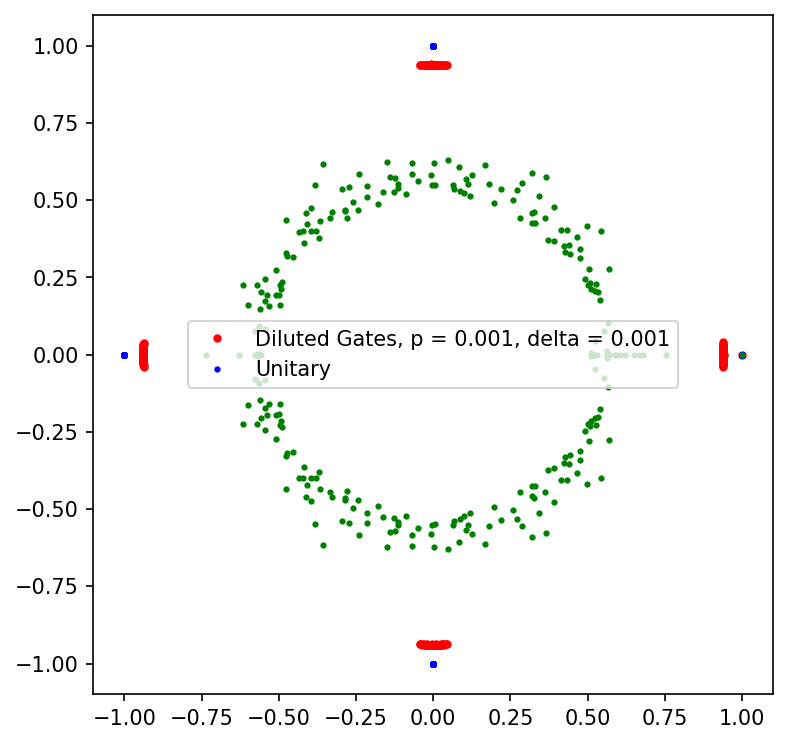

In [71]:
channel_model = model1.channel


p = 0.001
delta = 0.001

channel = circuit_to_concat_map(circuit, p = p, delta = delta)
channel = ConcatChannel([channel, unitary3_channel])
channel_model = ConcatChannel([channel_model, unitary3_channel])
spectrum1 = channel.spectrum()
spectrum_model = channel_model.spectrum()
spectrum2 = unitary2_channel.spectrum()

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(6,6), dpi = 150, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=3)
plt.plot(spectrum2[:,0], spectrum2[:,1], "bo", markersize=2)
plt.plot(spectrum_model[:,0], spectrum_model[:,1], "go", markersize=2)
plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])

C:\Users\krist\AppData\Local\Temp\ipykernel_28108\952127553.py:18: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002581CC16170> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])


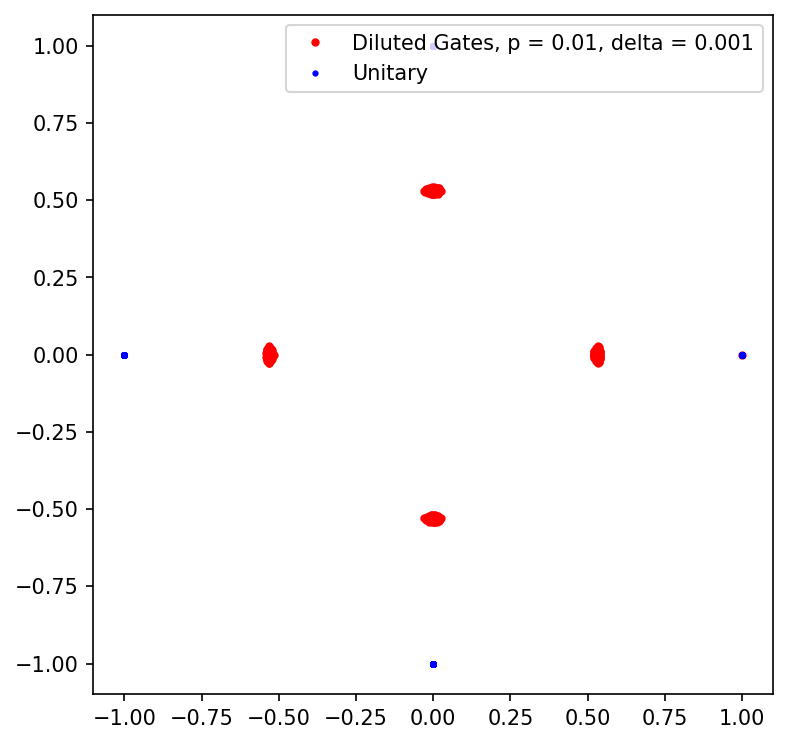

In [60]:
p = 0.01
delta = 0.001

channel = circuit_to_concat_map(circuit, p = p, delta = delta)
channel = ConcatChannel([channel, unitary3_channel])
spectrum1 = channel.spectrum()

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(6,6), dpi = 150, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=3)
plt.plot(spectrum2[:,0], spectrum2[:,1], "bo", markersize=2)
plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])

C:\Users\krist\AppData\Local\Temp\ipykernel_28108\4252793247.py:18: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000258186B0A00> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])


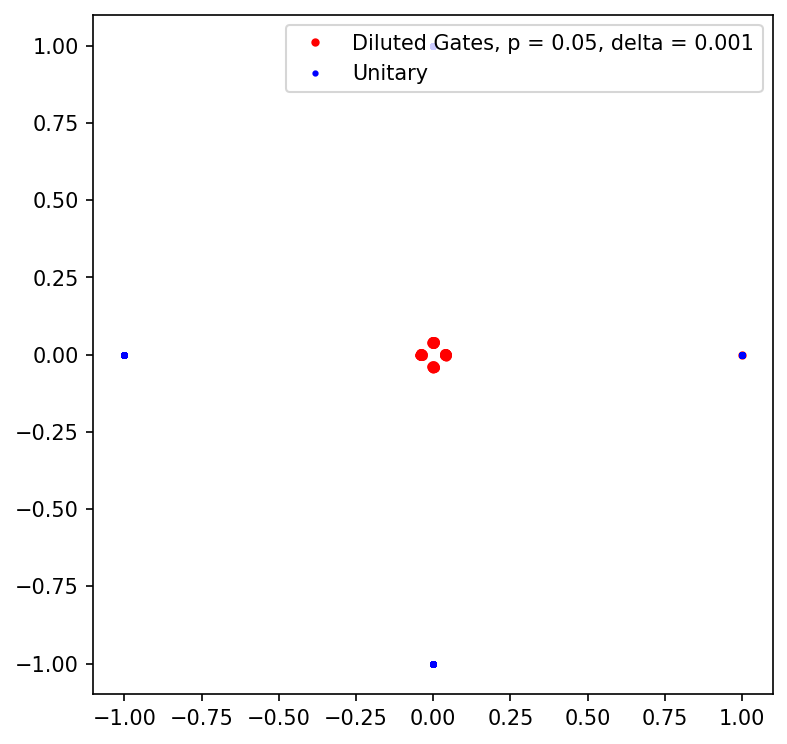

In [61]:
p = 0.05
delta = 0.001

channel = circuit_to_concat_map(circuit, p = p, delta = delta)
channel = ConcatChannel([channel, unitary3_channel])
spectrum1 = channel.spectrum()

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(6,6), dpi = 150, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=3)
plt.plot(spectrum2[:,0], spectrum2[:,1], "bo", markersize=2)
plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])

C:\Users\krist\AppData\Local\Temp\ipykernel_28108\1838606114.py:15: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002580A298190> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Diluted Gates", "Unitary"])


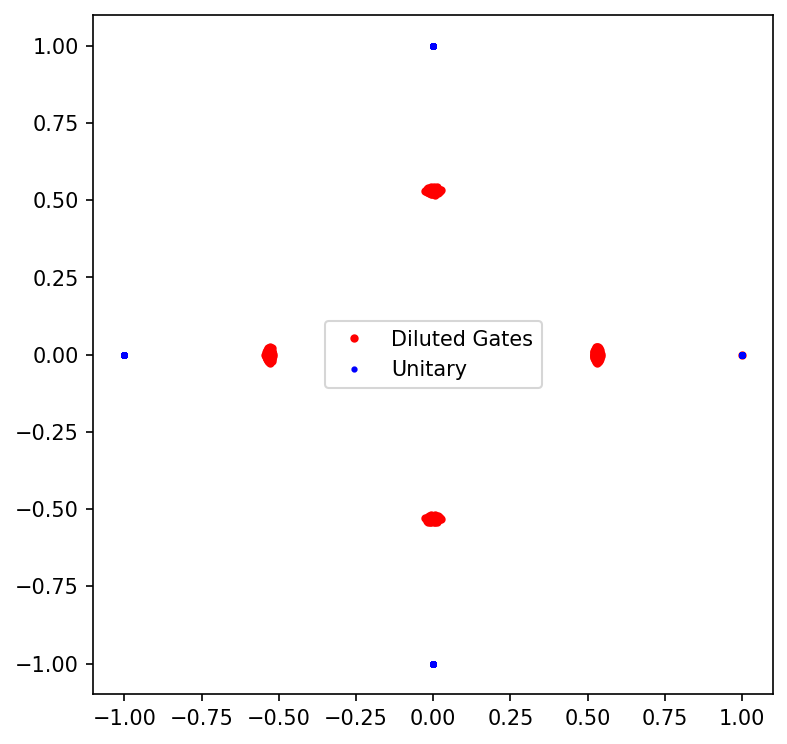

In [ ]:
p = 0.01
delta = 0.001

channel = circuit_to_concat_map(circuit, p = p, delta = delta)
channel = ConcatChannel([channel, unitary3_channel])
spectrum1 = channel.spectrum()

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(6,6), dpi = 150, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=3)
plt.plot(spectrum2[:,0], spectrum2[:,1], "bo", markersize=2)
plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])

C:\Users\krist\AppData\Local\Temp\ipykernel_28108\2748110639.py:18: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000025812EEB190> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])


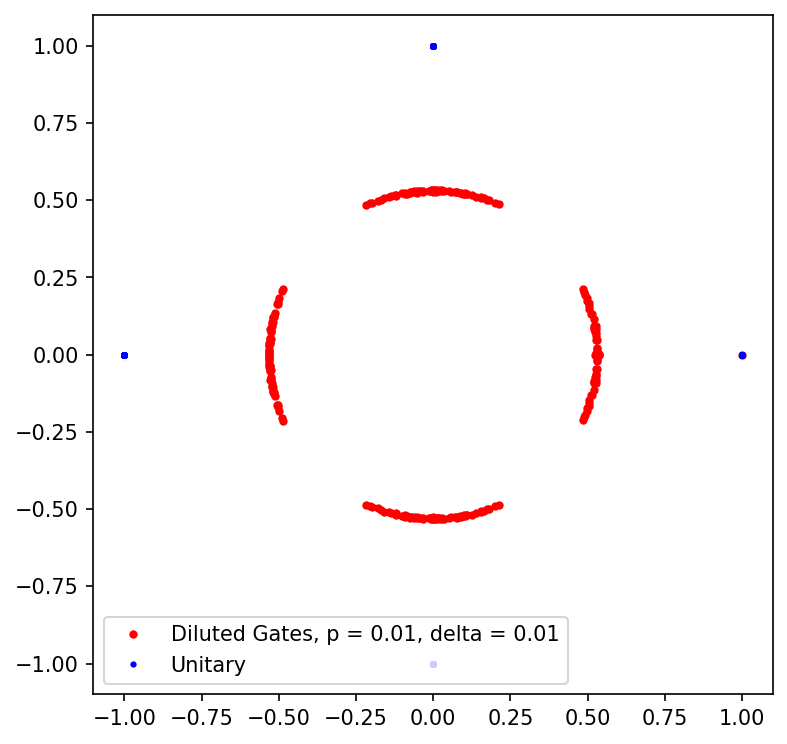

In [62]:
p = 0.01
delta = 0.01

channel = circuit_to_concat_map(circuit, p = p, delta = delta)
channel = ConcatChannel([channel, unitary3_channel])
spectrum1 = channel.spectrum()

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(6,6), dpi = 150, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=3)
plt.plot(spectrum2[:,0], spectrum2[:,1], "bo", markersize=2)
plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])

C:\Users\krist\AppData\Local\Temp\ipykernel_28108\2834287546.py:18: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000258257DF850> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])


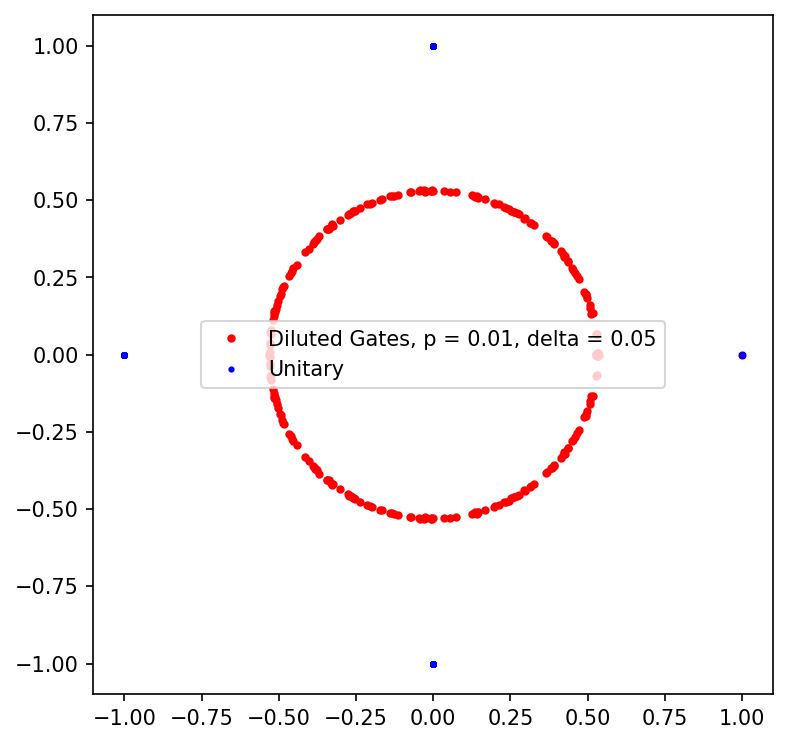

In [63]:
p = 0.01
delta = 0.05

channel = circuit_to_concat_map(circuit, p = p, delta = delta)
channel = ConcatChannel([channel, unitary3_channel])
spectrum1 = channel.spectrum()

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(6,6), dpi = 150, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=3)
plt.plot(spectrum2[:,0], spectrum2[:,1], "bo", markersize=2)
plt.legend(["_", f"Diluted Gates, p = {p}, delta = {delta}", "Unitary"])